## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline 
#qt
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

nx = 9
ny = 6

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        #cv2.imshow('img',img)
        #cv2.waitKey(100)

cv2.destroyAllWindows()



## And so on and so forth...

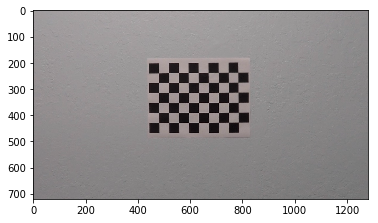

In [2]:
img = cv2.imread('../camera_cal/calibration6.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
dst_img = cv2.undistort(img, mtx, dist, None, mtx)
plt.imshow(dst_img)


True


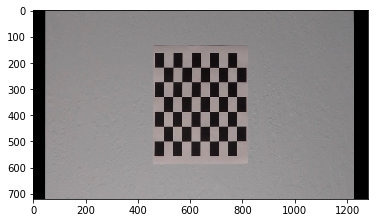

In [3]:
cv2.imshow('a',dst_img)

ret, corners = cv2.findChessboardCorners(dst_img, (nx,ny),None)

print(ret)

if ret:
    src = np.float32([corners[0], corners[nx-1], corners[nx*(ny-1)], corners[-1]])
    offset=500
    dst = np.float32([[offset,offset],[dst_img.shape[1]-offset,offset],
                      [offset,dst_img.shape[0]-offset],[dst_img.shape[1]-offset,dst_img.shape[0]-offset]])

    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)

    warped = cv2.warpPerspective(dst_img, M, (dst_img.shape[1],dst_img.shape[0]), flags=cv2.INTER_LINEAR)
    
    plt.imshow(warped)
    plt.show()
    
    #cv2.imshow('img unwarped', warped)

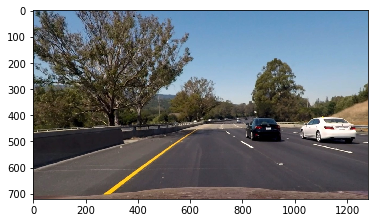

In [4]:
img = cv2.imread("../test_images/test6.jpg")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
undistort_img = cv2.undistort(img, mtx, dist, None, mtx)
plt.imshow(cv2.cvtColor(undistort_img, cv2.COLOR_BGR2RGB))
plt.show()
#cv2.imshow()'a',undistort_img)

720 1280


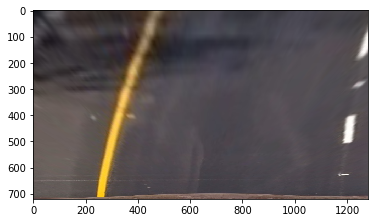

In [5]:
h,w,b = undistort_img.shape
print(h,w)

#src = np.float32([[575,450],[700,450],[0,h],[w,h]])
#dst = np.float32([[0,0],[w,0],[0,h],[w,h]])

src = np.float32([[550,460],[730,460],[0,h],[w,h]])
dst = np.float32([[0,0],[w,0],[0,h],[w,h]])

#src = np.float32([[w/2- 0,h/2+100],[w/6-10,h],[w*5/6+60,h],[w/2+60,h/2+100]])
#dst = np.float32([[w/4,0],[w/4,h],[w*3/4,h],[w*3/4,0]])

M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

warped = cv2.warpPerspective(undistort_img, M, (w,h), flags=cv2.INTER_LINEAR)

plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))

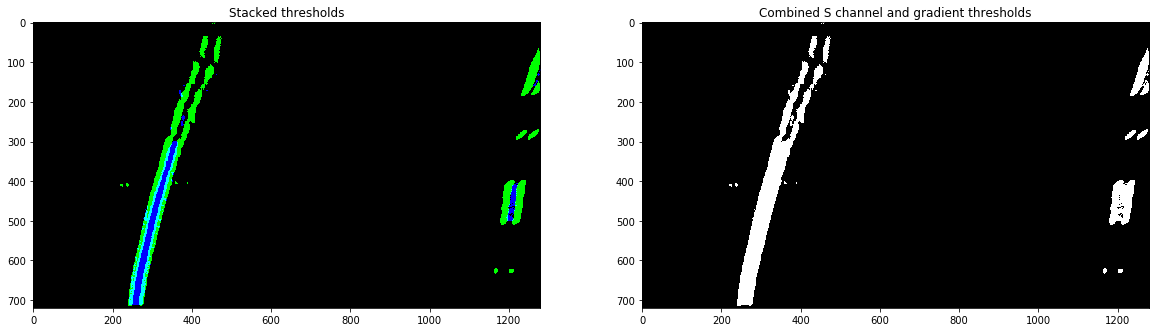

In [6]:

hls = cv2.cvtColor(warped, cv2.COLOR_RGB2HLS)
s_channel = hls[:,:,2]

# Grayscale image
# NOTE: we already saw that standard grayscaling lost color information for the lane lines
# Explore gradients in other colors spaces / color channels to see what might work better
gray = cv2.cvtColor(warped, cv2.COLOR_RGB2GRAY)

kernel = np.ones((11,11),np.float32)/25
#gray = cv2.filter2D(gray,-1,kernel)
gray = cv2.blur(gray,(11,11))

# Sobel x
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

# Threshold x gradient
thresh_min = 50
thresh_max = 255
sxbinary = np.zeros_like(scaled_sobel)
sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

# Threshold color channel
s_thresh_min = 150
s_thresh_max = 255
s_binary = np.zeros_like(s_channel)
s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

# Stack each channel to view their individual contributions in green and blue respectively
# This returns a stack of the two binary images, whose components you can see as different colors
color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

# Combine the two binary thresholds
binary_warped = np.zeros_like(sxbinary)
binary_warped[(s_binary == 1) | (sxbinary == 1)] = 1

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Stacked thresholds')
ax1.imshow(color_binary)

ax2.set_title('Combined S channel and gradient thresholds')
ax2.imshow(binary_warped, cmap='gray')

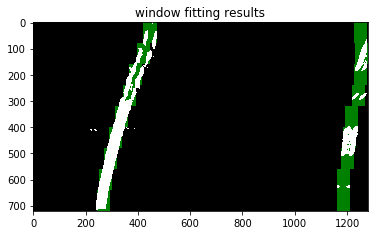

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import cv2

# Read in a thresholded image
#warped = mpimg.imread('warped_example.jpg')
# window settings
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 50 # How much to slide left and right for searching

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(image.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,image.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,image.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids

window_centroids = find_window_centroids(binary_warped, window_width, window_height, margin)

# If we found any window centers
if len(window_centroids) > 0:

    # Points used to draw all the left and right windows
    l_points = np.zeros_like(binary_warped)
    r_points = np.zeros_like(binary_warped)

    # Go through each level and draw the windows
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
        l_mask = window_mask(window_width,window_height,binary_warped,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,binary_warped,window_centroids[level][1],level)
        # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channel
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage= np.dstack((binary_warped, binary_warped, binary_warped))*255 # making the original road pixels 3 color channels
    output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
 
# If no window centers found, just display orginal road image
else:
    output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

# Display the final results
plt.imshow(output)
plt.title('window fitting results')
plt.show()


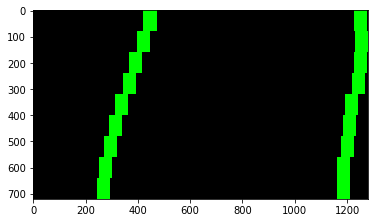

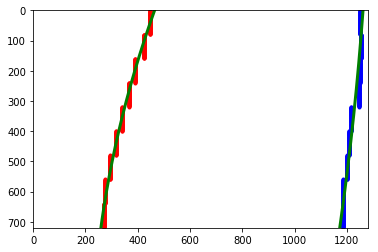

In [8]:
plt.imshow(template)
plt.show()

curve_img = np.array(r_points+l_points,np.uint8)

left_curve_y = []
right_curve_y = []
curve_x = np.linspace(0, 719, num=720)

for i in range(curve_img.shape[0]):
    
    left_curve_y.append(np.mean(l_points[i,:].nonzero()))
    right_curve_y.append(np.mean(r_points[i,:].nonzero()))

# Fit a second order polynomial to pixel positions in each fake lane line
left_fit = np.polyfit(curve_x, left_curve_y, 2)
left_fity = left_fit[0]*curve_x**2 + left_fit[1]*curve_x + left_fit[2]
right_fit = np.polyfit(curve_x, right_curve_y, 2)
right_fity = right_fit[0]*curve_x**2 + right_fit[1]*curve_x + right_fit[2]

# Plot up the data
mark_size = 3
plt.plot(left_curve_y, curve_x, 'o', color='red', markersize=mark_size)
plt.plot(right_curve_y, curve_x, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fity, curve_x, color='green', linewidth=3)
plt.plot(right_fity, curve_x, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images

In [9]:
y_eval = np.max(curve_x)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)
# Define conversions in x and y from pixels space to meters
xm_per_pix = 30/720 # meters per pixel in y dimension
ym_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(curve_x*ym_per_pix, left_fity*xm_per_pix, 2)
right_fit_cr = np.polyfit(curve_x*ym_per_pix, right_fity*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m

2900.42211192 9256.90869789
7.52375694358 m 26.0046811246 m


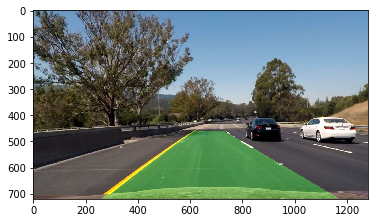

In [10]:
warp_zero = np.zeros_like(warped).astype(np.uint8)
#color_warp = np.dstack((warp_zero)), warp_zero, warp_zero))
color_warp = np.copy(warp_zero)

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fity, curve_x]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fity, curve_x])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (w, h)) 
# Combine the result with the original image
result = cv2.addWeighted(undistort_img, 1, newwarp, 0.3, 0)
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))

In [71]:
# this function takes input as undistorted image color image
def process_image_debug(img):
    
    window_width = 50 
    window_height = 80 # Break image into 9 vertical layers since image height is 720
    margin = 50 # How much to slide left and right for searching
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    plt.imshow(img)
    plt.show()
    h,w,b = img.shape

    #src = np.float32([[550,460],[730,460],[0,h],[w,h]])
    src = np.float32([[590,440],[690,440],[0,h],[w,h]])
    dst = np.float32([[0,0],[w,0],[0,h],[w,h]])

    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)

    warped = cv2.warpPerspective(gray, M, (w,h), flags=cv2.INTER_LINEAR)
    warped_rgb = cv2.warpPerspective(img, M, (w,h), flags=cv2.INTER_LINEAR)
    plt.imshow(warped)
    plt.show()
    
    hls = cv2.cvtColor(warped_rgb, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]


    kernel = np.ones((11,11),np.float32)/25
    #gray = cv2.filter2D(gray,-1,kernel)
    warped = cv2.blur(warped,(11,11))

    # Sobel x
    sobelx = cv2.Sobel(warped, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = 50
    thresh_max = 255
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Threshold color channel
    s_thresh_min = 150
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

    # Combine the two binary thresholds
    binary_warped = np.zeros_like(sxbinary)
    binary_warped[(s_binary == 1) | (sxbinary == 1)] = 1
    
    
    # Plotting thresholded images
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.set_title('Stacked thresholds')
    ax1.imshow(color_binary)

    ax2.set_title('Combined S channel and gradient thresholds')
    ax2.imshow(binary_warped, cmap='gray')
    
    window_centroids = find_window_centroids(binary_warped, window_width, window_height, margin)

    # If we found any window centers
    if len(window_centroids) > 0:

        # Points used to draw all the left and right windows
        l_points = np.zeros_like(binary_warped)
        r_points = np.zeros_like(binary_warped)

        # Go through each level and draw the windows 	
        for level in range(0,len(window_centroids)):
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,binary_warped,window_centroids[level][0],level)
            r_mask = window_mask(window_width,window_height,binary_warped,window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found 
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

        # Draw the results
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channel
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
        warpage= np.dstack((binary_warped, binary_warped, binary_warped))*255 # making the original road pixels 3 color channels
        output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results

    # If no window centers found, just display orginal road image
    else:
        output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

    # Display the final results
    
    plt.imshow(output)
    plt.title('window fitting results')
    plt.show()
    
    plt.imshow(template)
    plt.show()

    curve_img = np.array(r_points+l_points,np.uint8)

    left_curve_y = []
    right_curve_y = []
    curve_x = np.linspace(0, 719, num=720)
    
    for i in range(curve_img.shape[0]):
        temp = l_points[i,:].nonzero()[0]
        if(temp!=[]):
            left_curve_y.append(np.mean(temp))
        else:
            left_curve_y.append(0)
        
        temp = r_points[i,:].nonzero()[0]
        if(temp!=[]):
            right_curve_y.append(np.mean(temp))
        else:
            right_curve_y.append(w-1)
    
    
    # Fit a second order polynomial to pixel positions in each fake lane line
    left_fit = np.polyfit(curve_x, left_curve_y, 2)
    left_fity = left_fit[0]*curve_x**2 + left_fit[1]*curve_x + left_fit[2]
    right_fit = np.polyfit(curve_x, right_curve_y, 2)
    right_fity = right_fit[0]*curve_x**2 + right_fit[1]*curve_x + right_fit[2]

    # Plot up the data
    
    mark_size = 3
    plt.plot(left_curve_y, curve_x, 'o', color='red', markersize=mark_size)
    plt.plot(right_curve_y, curve_x, 'o', color='blue', markersize=mark_size)
    plt.xlim(0, 1280)
    plt.ylim(0, 720)
    plt.plot(left_fity, curve_x, color='green', linewidth=3)
    plt.plot(right_fity, curve_x, color='green', linewidth=3)
    plt.gca().invert_yaxis() # to visualize as we do the images
    y_eval = np.max(curve_x)
    
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    #print(left_curverad, right_curverad)
    # Define conversions in x and y from pixels space to meters
    xm_per_pix = 30/720 # meters per pixel in y dimension
    ym_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(curve_x*ym_per_pix, left_fity*xm_per_pix, 2)
    right_fit_cr = np.polyfit(curve_x*ym_per_pix, right_fity*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    #print(left_curverad, 'm', right_curverad, 'm')
    # Example values: 632.1 m    626.2 m
    
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    pts_left = np.array([np.transpose(np.vstack([left_fity, curve_x]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fity, curve_x])))])
    pts = np.hstack((pts_left, pts_right))

    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    newwarp = cv2.warpPerspective(color_warp, Minv, (w, h)) 
    
    #print(newwarp.shape)
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    plt.show()
    #plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    plt.imshow(newwarp,cmap='gray')
    return result

In [64]:
# this function takes input as undistorted image color image
def process_image(img):
    
    window_width = 50 
    window_height = 80 # Break image into 9 vertical layers since image height is 720
    margin = 50 # How much to slide left and right for searching
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    #plt.show()
    h,w,b = img.shape

    src = np.float32([[550,460],[730,460],[0,h],[w,h]])
    dst = np.float32([[0,0],[w,0],[0,h],[w,h]])

    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)

    warped = cv2.warpPerspective(gray, M, (w,h), flags=cv2.INTER_LINEAR)
    warped_rgb = cv2.warpPerspective(img, M, (w,h), flags=cv2.INTER_LINEAR)
    #plt.imshow(warped)
    #plt.show()
    
    hls = cv2.cvtColor(warped_rgb, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]


    kernel = np.ones((11,11),np.float32)/25
    warped = cv2.filter2D(gray,-1,kernel)
    #warped = cv2.blur(warped,(11,11))

    # Sobel x
    sobelx = cv2.Sobel(warped, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = 50
    thresh_max = 255
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Threshold color channel
    s_thresh_min = 150
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

    # Combine the two binary thresholds
    binary_warped = np.zeros_like(sxbinary)
    binary_warped[(s_binary == 1) | (sxbinary == 1)] = 1
    
    '''
    # Plotting thresholded images
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.set_title('Stacked thresholds')
    ax1.imshow(color_binary)

    ax2.set_title('Combined S channel and gradient thresholds')
    ax2.imshow(binary_warped, cmap='gray')'''
    
    window_centroids = find_window_centroids(binary_warped, window_width, window_height, margin)

    # If we found any window centers
    if len(window_centroids) > 0:

        # Points used to draw all the left and right windows
        l_points = np.zeros_like(binary_warped)
        r_points = np.zeros_like(binary_warped)

        # Go through each level and draw the windows 	
        for level in range(0,len(window_centroids)):
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,binary_warped,window_centroids[level][0],level)
            r_mask = window_mask(window_width,window_height,binary_warped,window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found 
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

        # Draw the results
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channel
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
        warpage= np.dstack((binary_warped, binary_warped, binary_warped))*255 # making the original road pixels 3 color channels
        output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results

    # If no window centers found, just display orginal road image
    else:
        output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

    # Display the final results
    '''
    plt.imshow(output)
    plt.title('window fitting results')
    plt.show()
    
    plt.imshow(template)
    plt.show()'''

    curve_img = np.array(r_points+l_points,np.uint8)

    left_curve_y = []
    right_curve_y = []
    curve_x = np.linspace(0, 719, num=720)

    for i in range(curve_img.shape[0]):
        temp = l_points[i,:].nonzero()[0]
        if(temp!=[]):
            left_curve_y.append(np.mean(temp))
        else:
            left_curve_y.append(0)
        
        temp = r_points[i,:].nonzero()[0]
        if(temp!=[]):
            right_curve_y.append(np.mean(temp))
        else:
            right_curve_y.append(w-1)

    # Fit a second order polynomial to pixel positions in each fake lane line
    left_fit = np.polyfit(curve_x, left_curve_y, 2)
    left_fity = left_fit[0]*curve_x**2 + left_fit[1]*curve_x + left_fit[2]
    right_fit = np.polyfit(curve_x, right_curve_y, 2)
    right_fity = right_fit[0]*curve_x**2 + right_fit[1]*curve_x + right_fit[2]

    # Plot up the data
    '''
    mark_size = 3
    plt.plot(left_curve_y, curve_x, 'o', color='red', markersize=mark_size)
    plt.plot(right_curve_y, curve_x, 'o', color='blue', markersize=mark_size)
    plt.xlim(0, 1280)
    plt.ylim(0, 720)
    plt.plot(left_fity, curve_x, color='green', linewidth=3)
    plt.plot(right_fity, curve_x, color='green', linewidth=3)
    plt.gca().invert_yaxis() # to visualize as we do the images'''
    y_eval = np.max(curve_x)
    
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    #print(left_curverad, right_curverad)
    # Define conversions in x and y from pixels space to meters
    xm_per_pix = 30/720 # meters per pixel in y dimension
    ym_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(curve_x*ym_per_pix, left_fity*xm_per_pix, 2)
    right_fit_cr = np.polyfit(curve_x*ym_per_pix, right_fity*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    #print(left_curverad, 'm', right_curverad, 'm')
    # Example values: 632.1 m    626.2 m
    
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    pts_left = np.array([np.transpose(np.vstack([left_fity, curve_x]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fity, curve_x])))])
    pts = np.hstack((pts_left, pts_right))

    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    newwarp = cv2.warpPerspective(color_warp, Minv, (w, h)) 
    
    #print(newwarp.shape)
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    #plt.show()
    #plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    #plt.imshow(newwarp,cmap='gray')
    return cv2.cvtColor(result, cv2.COLOR_BGR2RGB)

In [65]:
def calibrate_camera():
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    nx = 9
    ny = 6

    # Make a list of calibration images
    images = glob.glob('../camera_cal/calibration*.jpg')

    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
            #cv2.imshow('img',img)
            #cv2.waitKey(100)

    #cv2.destroyAllWindows()
    return objpoints, imgpoints

In [75]:
def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(image.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,image.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,image.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids

(720, 1280, 3)


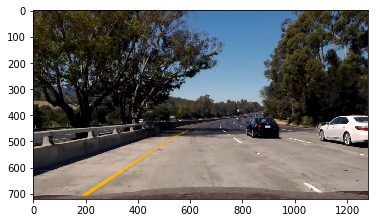

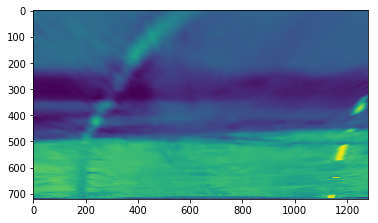

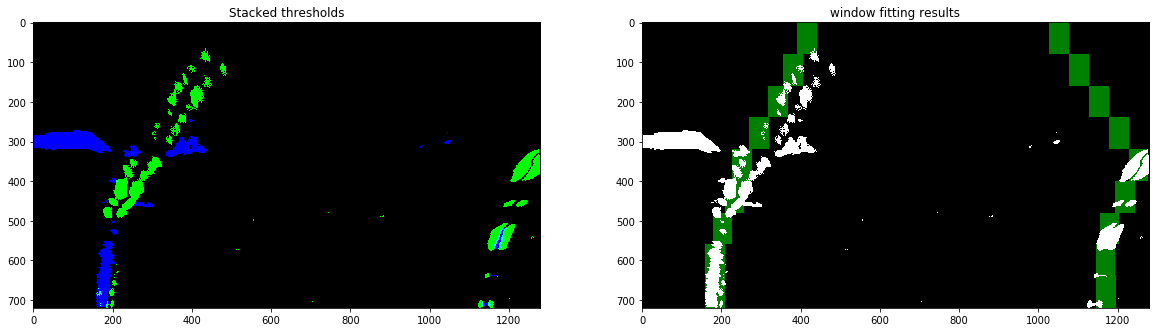

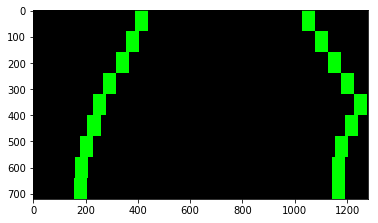

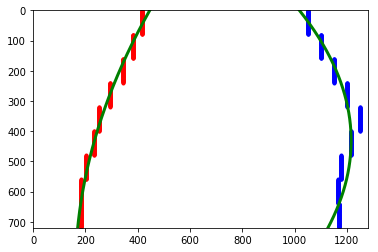

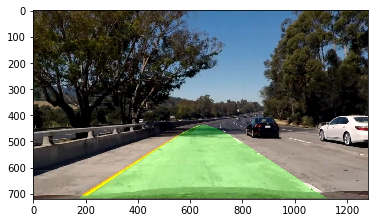

In [76]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline 

#img = cv2.imread("../test_images/test6.jpg")
img = cv2.imread("../video_samples_shadab/project_video/frame41.jpeg")
print(img.shape)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

objpoints, imgpoints = calibrate_camera()
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
#print(ret,mtx,dist,rvecs,tvecs)

if ret:
    undistort_img = cv2.undistort(img, mtx, dist, None, mtx)
    plt.imshow(process_image_debug(undistort_img))

In [5]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import moviepy.editor as mpy
white_output = '../challenge_video_output.mp4'
#clip1 = mpy.VideoFileClip("../project_video.mp4").subclip(1,2)
clip1 = mpy.VideoFileClip("../challenge_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video ../challenge_video_output.mp4
[MoviePy] Writing video ../challenge_video_output.mp4


100%|████████████████████████████████████████| 485/485 [02:31<00:00,  3.25it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../challenge_video_output.mp4 

Wall time: 2min 34s
